In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('fake_job_postings.csv')

In [7]:
data.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [10]:
#sentiment count
data['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [11]:
#split the dataset  
#train dataset
train_description=data.description[:12000]
train_fraudulent=data.fraudulent[:12000]
#test dataset
test_description=data.description[12000:]
test_fraudulent=data.fraudulent[12000:]
print(train_description.shape,train_fraudulent.shape)
print(test_description.shape,test_fraudulent.shape)

(12000,) (12000,)
(5880,) (5880,)


In [12]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [17]:
data['description'] = data['description'].astype(str)

In [18]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
data['description']=data['description'].apply(denoise_text)

In [19]:
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
data['description']=data['description'].apply(remove_special_characters)

In [20]:
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
data['description']=data['description'].apply(simple_stemmer)

In [21]:
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
data['description']=data['description'].apply(remove_stopwords)


{'very', "should've", 'most', 'wouldn', "haven't", 'can', 'here', 'herself', 'at', 'were', 'in', 'shan', "don't", 'she', 'does', 'such', 'about', 'i', 'between', "aren't", 'both', 'out', "isn't", 'mustn', 'had', 'who', "you'll", 'no', 'needn', 'down', 'we', 'their', 'an', 'did', "couldn't", 'are', 'and', "wouldn't", 'your', 'into', 'on', 'having', 're', 'have', 'be', 't', "you've", 'ourselves', 'itself', "mightn't", 'y', "doesn't", 've', 'all', 'shouldn', 'wasn', 'its', "wasn't", 'hadn', 'then', 'against', 'only', 'themselves', 'those', 'what', 'before', "you'd", 'or', 'through', 'some', 'this', 'myself', 'how', 'more', 'him', 'weren', 'hers', 'than', 'a', "you're", 'once', 'am', 'any', 'too', 'didn', 'these', 'his', 'is', 'now', 'the', 'until', 'above', 'me', 'yourselves', 'just', 'for', 'over', 'm', 'which', 'theirs', 'ain', 'd', 'so', 'has', 'while', 'yours', 'up', 'as', 'few', 'during', 'aren', 'being', 'off', 'own', 'again', 'because', 'ours', "hasn't", "won't", 'from', 'll', 'doi

In [26]:
norm_train_description=data.description[:12000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'food52 fastgrow jame beard awardwin onlin food commun crowdsourc curat recip hub current interview full parttim unpaid intern work small team editor execut develop new york citi headquartersreproduc andor repackag exist food52 content number partner site huffington post yahoo buzzfe variou content manag systemsresearch blog websit provis food52 affili programassist daytoday affili program support screen affili assist ani affili inquiriessupport PR event neededhelp offic administr work file mail prepar meetingswork develop document bug suggest improv sitesupport market execut staff'

In [29]:
#Normalized test description
norm_test_description=data.description[12000:]
norm_test_description[12005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'hopper travel startup base cambridg montreal qcwe combin insight research massiv data set intuit design help travel make better decis go fli buywer look intrepid individu join team busi develop expert focus discov foster essenti partnership airlin onlin travel agenc major player travel industri structur develop partnership pipelin drive hopper industri growth tangibl impact day one best person thi role except commun passion mission educ travel datadriven insight improv way world research book travelprior experi similar role consum travel onlin consum brand requir candidaturein thi role willseek initi develop valuabl partnership opportun align evolv product goal prioritiesown full partnership cycl first contact product implement relationship managementlead aspect deal negoti ensur parti need expect optim metwork close product dev team smoothli integr partner data servic core productsact bridg need technic team outsid partner contact'

In [30]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_description=cv.fit_transform(norm_train_description)
#transformed test reviews
cv_test_description=cv.transform(norm_test_description)

print('BOW_cv_train:',cv_train_description.shape)
print('BOW_cv_test:',cv_test_description.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (12000, 886687)
BOW_cv_test: (5880, 886687)


In [32]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_description=tv.fit_transform(norm_train_description)
#transformed test reviews
tv_test_description=tv.transform(norm_test_description)
print('Tfidf_train:',tv_train_descriptio`n.shape)
print('Tfidf_test:',tv_test_description.shape)

Tfidf_train: (12000, 886687)
Tfidf_test: (5880, 886687)


In [33]:
#labeling the data
lb=LabelBinarizer()
#transformed description data
description_data=lb.fit_transform(data['description'])
print(description_data.shape)

(17880, 14504)


In [35]:
#Spliting the description data
train_description=description_data[:12000]
test_description=description_data[12000:]
print(train_description)
print(test_description)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_description,train_fraudulent)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_description,train_fraudulent)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [37]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_description)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_description)
print(lr_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [38]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_fraudulent,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_fraudulent,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.9437074829931973
lr_tfidf_score : 0.9386054421768707


In [41]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_fraudulent,lr_bow_predict,target_names=['True','Fake'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_fraudulent,lr_tfidf_predict,target_names=['True','Fake'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

        True       0.94      1.00      0.97      5519
        Fake       1.00      0.08      0.15       361

    accuracy                           0.94      5880
   macro avg       0.97      0.54      0.56      5880
weighted avg       0.95      0.94      0.92      5880

              precision    recall  f1-score   support

        True       0.94      1.00      0.97      5519
        Fake       0.00      0.00      0.00       361

    accuracy                           0.94      5880
   macro avg       0.47      0.50      0.48      5880
weighted avg       0.88      0.94      0.91      5880



In [43]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_fraudulent,lr_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_fraudulent,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)


[[  30  331]
 [   0 5519]]
[[   0  361]
 [   0 5519]]


In [50]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_description,train_fraudulent)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_description,train_fraudulent)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [51]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_description)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_description)
print(mnb_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [52]:
mnb_bow_score=accuracy_score(test_fraudulent,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_fraudulent,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.9287414965986395
mnb_tfidf_score : 0.9386054421768707


In [54]:
#Classification report for bag of words 
mnb_bow_report=classification_report(test_fraudulent,mnb_bow_predict,target_names=['True','Fake'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_fraudulent,mnb_tfidf_predict,target_names=['True','Fake'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

        True       0.94      0.98      0.96      5519
        Fake       0.27      0.10      0.14       361

    accuracy                           0.93      5880
   macro avg       0.61      0.54      0.55      5880
weighted avg       0.90      0.93      0.91      5880

              precision    recall  f1-score   support

        True       0.94      1.00      0.97      5519
        Fake       0.00      0.00      0.00       361

    accuracy                           0.94      5880
   macro avg       0.47      0.50      0.48      5880
weighted avg       0.88      0.94      0.91      5880



In [55]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_fraudulent,mnb_bow_predict,labels=[1,0])
print(cm_bow)
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_fraudulent,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[  35  326]
 [  93 5426]]
[[   0  361]
 [   0 5519]]


In [60]:
#training the model
rfc = ensemble.RandomForestClassifier()
#fitting the svm for bag of words
rfc_bow=rfc.fit(cv_train_description,train_fraudulent)
print(rfc_bow)
#fitting the svm for tfidf features
rfc_tfidf=rfc.fit(tv_train_description,train_fraudulent)
print(rfc_tfidf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [64]:
#Predicting the model for bag of words
rfc_bow_predict=rfc.predict(cv_test_description)
print(rfc_bow_predict)
#Predicting the model for tfidf features
rfc_tfidf_predict=rfc.predict(tv_test_description)
print(clf_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [65]:
#confusion matrix for bag of words
rfc_bow=confusion_matrix(test_fraudulent,rfc_bow_predict,labels=[1,0])
print(rfc_bow)
#confusion matrix for tfidf features
rfc_tfidf=confusion_matrix(test_fraudulent,rfc_tfidf_predict,labels=[1,0])
print(rfc_tfidf)

[[  28  333]
 [   1 5518]]
[[  28  333]
 [   0 5519]]


In [59]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

#training the model
clf = ensemble.GradientBoostingClassifier()
#fitting the svm for bag of words
clf_bow=clf.fit(cv_train_description,train_fraudulent)
print(clf_bow)
#fitting the svm for tfidf features
clf_tfidf=clf.fit(tv_train_description,train_fraudulent)
print(clf_tfidf)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples

In [63]:
#Predicting the model for bag of words
clf_bow_predict=clf.predict(cv_test_description)
print(clf_bow_predict)
#Predicting the model for tfidf features
clf_tfidf_predict=clf.predict(tv_test_description)
print(clf_tfidf_predict)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


<function matplotlib.pyplot.show(*args, **kw)>

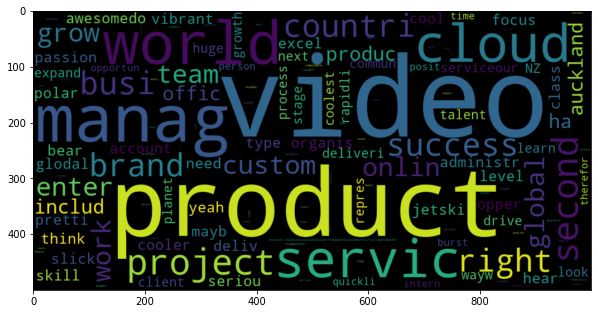

In [56]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_description[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

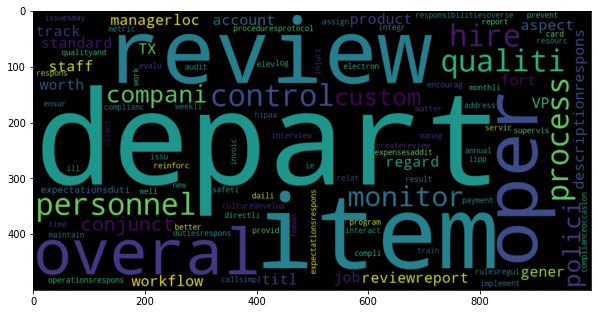

In [69]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_description[4]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show